# Dataset Preparation Notebook

This notebook goes through the data collection and preparation for training the density map model. It performs the train-test split on the VisDrone2020 Dataset, prepares the images and labels directories and creates ground truth density maps.

In [4]:
# imports
import cv2
import numpy as np
import os
import random
import shutil
import h5py
import glob
from PIL import Image

from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

## Perform the data split on the VisDrone2020

We create a new dataset directory where we split the dataset into train, test and val. The test set will only have images as we do not have ground truth labels. The validation set is a 20% split of the trainlist and will be used for evaluating our model.

In [2]:
# Dataset paths
dataset_path = 'Data/VisDrone2020-CC'
sequences_path = os.path.join(dataset_path, 'sequences')
annotations_path = os.path.join(dataset_path, 'annotations')

# New dataset paths
new_dataset_path = 'Data/VisDrone2020-Prepared'
train_path = os.path.join(new_dataset_path, 'train')
val_path = os.path.join(new_dataset_path, 'val')
test_path = os.path.join(new_dataset_path, 'test')

def process_split(sequences, images_output_path, labels_output_path, is_test=False):
    os.makedirs(images_output_path, exist_ok=True)
    if not is_test:
        os.makedirs(labels_output_path, exist_ok=True)

    for seq_id in sequences:
        # Process images
        seq_images_path = os.path.join(sequences_path, seq_id)
        for image_file in os.listdir(seq_images_path):
            src_image_path = os.path.join(seq_images_path, image_file)
            dst_image_path = os.path.join(images_output_path, f'{seq_id}_{image_file}')
            shutil.copy(src_image_path, dst_image_path)

        if not is_test:
            # Process annotations
            annotation_file = os.path.join(annotations_path, f'{seq_id}.txt')
            with open(annotation_file, 'r') as file:
                annotations = file.read().splitlines()

            frame_annotations = {}
            for line in annotations:
                frame_id, x, y = line.split(',')
                frame_key = f'{seq_id}_{frame_id.zfill(5)}'
                if frame_key not in frame_annotations:
                    frame_annotations[frame_key] = []
                frame_annotations[frame_key].append(f'{x} {y}')

            for frame_key, coords in frame_annotations.items():
                label_file_path = os.path.join(labels_output_path, f'{frame_key}.txt')
                with open(label_file_path, 'w') as label_file:
                    label_file.write('\n'.join(coords))

# Read sequence names for train, val, and test splits
with open(os.path.join(dataset_path, 'trainlist.txt'), 'r') as file:
    train_sequences = file.read().splitlines()

with open(os.path.join(dataset_path, 'testlist.txt'), 'r') as file:
    test_sequences = file.read().splitlines()

# Split train sequences into train and validation sets
random.shuffle(train_sequences)
val_size = int(len(train_sequences) * 0.2)
val_sequences = train_sequences[:val_size]
train_sequences = train_sequences[val_size:]

train_images = os.path.join(train_path, 'images')
train_labels = os.path.join(train_path, 'labels')

val_images = os.path.join(val_path, 'images')
val_labels = os.path.join(val_path, 'labels')

# Process train, validation, and test splits
process_split(train_sequences, train_images, train_labels)
process_split(val_sequences, val_images, val_labels)
process_split(test_sequences, os.path.join(test_path, 'images'), None, is_test=True)

print("Dataset processing complete.")

Dataset processing complete.


## Generate Ground Truth Density Maps

We generate groundtruth density maps for the train and val sets which are used for training our model. The images are also resized to reduce the computational complexity for training and the annotations are adjusted accordingly.

In [5]:
def resize_image(image, output_size):
    resized_image = image.resize(output_size, Image.LANCZOS)
    return np.array(resized_image)

def adjust_annotations(annotation_path, original_size, target_size):
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]
    with open(annotation_path, 'r') as file:
        adjusted_points = []
        for line in file:
            x, y = map(int, line.strip().split(' '))
            adjusted_x = min(int(x * scale_x), target_size[0] - 1)
            adjusted_y = min(int(y * scale_y), target_size[1] - 1)
            adjusted_points.append([adjusted_x, adjusted_y])
    return adjusted_points

def generate_density_map(image_size, points, sigma=15):
    density_map = np.zeros(image_size, dtype=np.float32)
    for point in points:
        density_map[point[1], point[0]] = 1
    density_map = gaussian_filter(density_map, sigma=sigma)
    return density_map

# Parameters
resize_to = (960, 540) # New size (width, height)

def ResizeSet(path, image_folder, input_annotation_folder):
    # Create subfolders for images and density maps
    output_density_map_folder = os.path.join(path, 'density_map')
    os.makedirs(output_density_map_folder, exist_ok=True)

    # Process each image and its corresponding annotations
    for image_path in glob.glob(os.path.join(image_folder, '*.jpg')):
        image_name = os.path.basename(image_path)
        annotation_path = os.path.join(input_annotation_folder, os.path.splitext(image_name)[0] + '.txt')

        # Resize image
        image = Image.open(image_path)
        original_image_size = image.size
        resized_image = resize_image(image, resize_to)
        cv2.imwrite(os.path.join(image_folder, image_name), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

        # Adjust annotation points
        adjusted_points = adjust_annotations(annotation_path, original_image_size, resize_to)

        # Generate density map
        density_map = generate_density_map(resized_image.shape[:2], adjusted_points)

        # Save density map as .h5 file
        density_map_file = h5py.File(os.path.join(output_density_map_folder, os.path.splitext(image_name)[0] + '.h5'), 'w')
        density_map_file.create_dataset('density', data=density_map)
        density_map_file.close()

ResizeSet(train_path, train_images, train_labels)
ResizeSet(val_path, val_images, val_labels)
print("All images processed and density maps saved.")

## Visualization of a density map

104


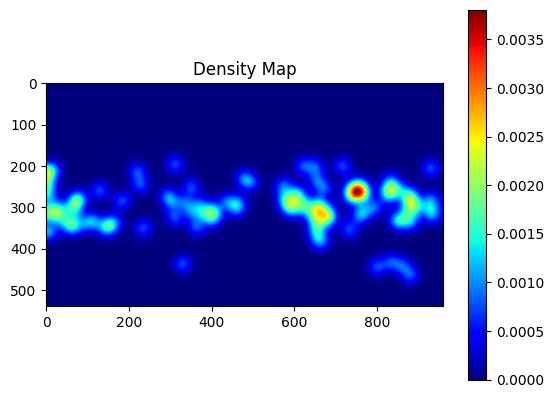

In [6]:
# Path to your density map file
density_dir_path = os.path.join(train_path, "density_map")
density_map_path = next((os.path.join(density_dir_path, file) for file in os.listdir(density_dir_path) if file.endswith('.h5')), None)

# Load density map from HDF5 file
with h5py.File(density_map_path, 'r') as hf:
    density_map = np.array(hf['density'])
print(round(density_map.sum()))
# Display the density map
plt.imshow(density_map, cmap='jet')
plt.colorbar()  # To show the scale of the density map
plt.title('Density Map')
plt.show()